In [1]:
# Importing all necessary packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Using pandas to import the dataset and creatig a dataframe

In [4]:
df = pd.read_csv('apple_tweets.csv',encoding='ISO-8859-1')

In [5]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [7]:
# Dropping all the columns and keeping only the tweets 

In [8]:
tweet_data=df.drop(columns=['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'sentiment', 'sentiment:confidence', 'date', 'id',
       'query', 'sentiment_gold'],axis=1)

In [9]:
tweet_data

,text
0,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,My cat only chews @apple cords. Such an #Apple...
3,I agree with @jimcramer that the #IndividualIn...
4,Nobody expects the Spanish Inquisition #AAPL
...,...
3881,(Via FC) Apple Is Warming Up To Social Media -...
3882,RT @MMLXIV: there is no avocado emoji may I as...
3883,@marcbulandr I could not agree more. Between @...
3884,My iPhone 5's photos are no longer downloading...


In [10]:
# Cleaning the tweets by removing special characters and https

In [11]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [12]:
tweet_data.text = tweet_data['text'].apply(data_processing)

In [13]:
#Dropping the duplicate tweets if any

In [14]:
tweet_data = tweet_data.drop_duplicates('text')

In [15]:
tweet_data.head()

,text
0,aaplthe 10 best steve jobs emails everhttptco8...
1,rt jpdesloges aapl stock miniflash crash today...
2,cat chews apple cords applesnob
3,agree jimcramer individualinvestor trade apple...
4,nobody expects spanish inquisition aapl


In [16]:
# Perform stemming on the cleaned data to get the root words

In [17]:
stemmer = LancasterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [18]:
tweet_data['text'] = tweet_data['text'].apply(lambda x: stemming(x))

In [19]:
tweet_data.head()

,text
0,aaplthe 10 best steve jobs emails everhttptco8...
1,rt jpdesloges aapl stock miniflash crash today...
2,cat chews apple cords applesnob
3,agree jimcramer individualinvestor trade apple...
4,nobody expects spanish inquisition aapl


In [20]:
# Using textblob to find the polarity  of the tweets

In [21]:
def polarity (text):
    return TextBlob(text).polarity

In [22]:
tweet_data['polarity'] = tweet_data['text'].apply(polarity)
tweet_data

,text,polarity
0,aaplthe 10 best steve jobs emails everhttptco8...,1.000000
1,rt jpdesloges aapl stock miniflash crash today...,0.000000
2,cat chews apple cords applesnob,0.000000
3,agree jimcramer individualinvestor trade apple...,0.700000
4,nobody expects spanish inquisition aapl,0.000000
...,...,...
3880,hey apple normal laptop charger soldering skin...,0.175000
3881,via fc apple warming social media apple hiring...,0.022222
3882,rt mmlxiv avocado emoji may ask apple,0.000000
3883,marcbulandr could agree apple twitter ibmwatso...,0.800000


In [23]:
#Find the range of polarity for each sentiment

In [24]:
tweet_data['polarity'].max()

1.0

In [25]:
tweet_data['polarity'].min()

-1.0

In [26]:
#Create a function to classify sentiment based on the polarity

In [27]:
def sentiment(label):
    if label > 0:
        return "Positive"
    elif label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"

In [28]:
tweet_data['sentiment'] = tweet_data['polarity'].apply(sentiment)
tweet_data

,text,polarity,sentiment
0,aaplthe 10 best steve jobs emails everhttptco8...,1.000000,Positive
1,rt jpdesloges aapl stock miniflash crash today...,0.000000,Neutral
2,cat chews apple cords applesnob,0.000000,Neutral
3,agree jimcramer individualinvestor trade apple...,0.700000,Positive
4,nobody expects spanish inquisition aapl,0.000000,Neutral
...,...,...,...
3880,hey apple normal laptop charger soldering skin...,0.175000,Positive
3881,via fc apple warming social media apple hiring...,0.022222,Positive
3882,rt mmlxiv avocado emoji may ask apple,0.000000,Neutral
3883,marcbulandr could agree apple twitter ibmwatso...,0.800000,Positive


In [29]:
#Visualise and count the number of tweets based on sentiment

<Axes: xlabel='sentiment', ylabel='count'>

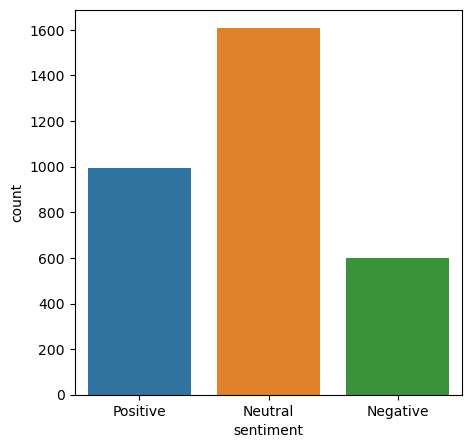

In [30]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = tweet_data)

In [31]:
len(tweet_data[tweet_data['sentiment']=='Positive'])

996

In [32]:
len(tweet_data[tweet_data['sentiment']=='Negative'])

598

In [33]:
len(tweet_data[tweet_data['sentiment']=='Neutral'])

1608

In [34]:
#Vectorise the tweets to fit into the model

In [35]:
 tfidf_vect = TfidfVectorizer(ngram_range=(1, 2)).fit(tweet_data['text'])

In [36]:
tfidf_vect

TfidfVectorizer(ngram_range=(1, 2))

In [37]:
 feature_names = tfidf_vect.get_feature_names_out()
 print("Number of features: {}\n".format(len(feature_names)))
 print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 28989

First 20 features:
 ['00' '00 setting' '0144' '0144 sick' '02' '02 2014' '03' '03 2014' '04'
 '04 2014' '04 apple' '05' '05 2014' '07' '07 amp' '08' '08 2014' '09'
 '09 apple' '099']


In [38]:
X = tweet_data['text']
y = tweet_data['sentiment']
X = tfidf_vect.transform (X)

In [39]:
# Split training and test data

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [41]:
#Create functions to implement model

In [42]:
def implement_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_acc = accuracy_score(model_pred, y_test)
    print("Test accuracy: {:.2f}%".format(model_acc * 100))
    print(confusion_matrix(y_test, model_pred))
    print("\n")
    print(classification_report(y_test, model_pred))

In [43]:
def HyperParameterTuning(model, param_grid, x_train, y_train, x_test, y_test,model_name):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    best_model = model.set_params(**best_params)
    best_model.fit(x_train, y_train)
    model_pred = best_model.predict(x_test)
    model_acc = accuracy_score(y_test, model_pred)
    print("Best Hyperparameters:", best_params)
    print("Test accuracy: {:.2f}%".format(model_acc * 100))
    print(confusion_matrix(y_test, model_pred))
    print("\n")
    print(classification_report(y_test, model_pred))
    model_save_path = 'hyper_'f'{model_name}.pkl'
    joblib.dump(model, model_save_path)
    return model

In [44]:
# Creating a Logistic Regression model and printing the results

In [45]:
logreg = LogisticRegression()
print("Logistic Regression Results:")
print("\n")
implement_model(logreg, x_train, y_train, x_test, y_test)

Logistic Regression Results:


Test accuracy: 73.95%
[[ 33  71   5]
 [  0 330   3]
 [  1  87 111]]


              precision    recall  f1-score   support

    Negative       0.97      0.30      0.46       109
     Neutral       0.68      0.99      0.80       333
    Positive       0.93      0.56      0.70       199

    accuracy                           0.74       641
   macro avg       0.86      0.62      0.65       641
weighted avg       0.81      0.74      0.71       641



In [46]:
# Creating a Random Forest model and printing the results

In [47]:
rf = RandomForestClassifier()
print("Random Forest Results:")
implement_model(rf, x_train, y_train, x_test, y_test)

Random Forest Results:
Test accuracy: 80.66%
[[ 50  51   8]
 [  1 331   1]
 [  3  60 136]]


              precision    recall  f1-score   support

    Negative       0.93      0.46      0.61       109
     Neutral       0.75      0.99      0.85       333
    Positive       0.94      0.68      0.79       199

    accuracy                           0.81       641
   macro avg       0.87      0.71      0.75       641
weighted avg       0.84      0.81      0.79       641



In [48]:
# Creating a Support Vector Machine model and printing the results

In [49]:
svm = SVC()
print("Support Vector Machine (SVM) Results:")
implement_model(svm, x_train, y_train, x_test, y_test)

Support Vector Machine (SVM) Results:
Test accuracy: 68.95%
[[ 30  77   2]
 [  0 332   1]
 [  1 118  80]]


              precision    recall  f1-score   support

    Negative       0.97      0.28      0.43       109
     Neutral       0.63      1.00      0.77       333
    Positive       0.96      0.40      0.57       199

    accuracy                           0.69       641
   macro avg       0.85      0.56      0.59       641
weighted avg       0.79      0.69      0.65       641



In [50]:
# Performing hyperparameter tuning for Support Vector Machine (SVM) using a grid search with specified parameters.

In [51]:
print("\n")
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
HyperParameterTuning(svm, svm_param_grid, x_train, y_train, x_test, y_test,'svm_model')



Best Hyperparameters: {'C': 10, 'kernel': 'linear'}
Test accuracy: 80.19%
[[ 55  47   7]
 [  6 320   7]
 [  1  59 139]]


              precision    recall  f1-score   support

    Negative       0.89      0.50      0.64       109
     Neutral       0.75      0.96      0.84       333
    Positive       0.91      0.70      0.79       199

    accuracy                           0.80       641
   macro avg       0.85      0.72      0.76       641
weighted avg       0.82      0.80      0.79       641



SVC(C=10, kernel='linear')

In [52]:
# Performing hyperparameter tuning for Random Forest using a grid search with specified parameters.

In [ ]:
print("\n")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
HyperParameterTuning(rf, rf_param_grid, x_train, y_train, x_test, y_test,'rf_model')

In [ ]:
print("\n")
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}
HyperParameterTuning(logreg, logreg_param_grid, x_train, y_train, x_test, y_test,'logreg_model')

In [ ]:
import tkinter as tk
from tkinter import ttk, messagebox
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import joblib

# Load the pre-trained SVM model and TF-IDF vectorizer
model = joblib.load('hyper_svm_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

def analyze_sentiment():
    # Get user input from the entry widget
    user_input = user_input_entry.get()

    # Check if the user entered any text
    if not user_input:
        messagebox.showinfo("Error", "Please enter some text.")
    else:
        # Preprocess user input
        user_input = data_processing(user_input)
        user_input = stemming(user_input)

        # Transform user input into a TF-IDF vector
        user_input_vector = tfidf_vectorizer.transform([user_input])

        # Predict sentiment using the pre-trained SVM model
        sentiment = model.predict(user_input_vector)

        # Display the sentiment result
        result_label.config(text=f"Sentiment: {sentiment[0]}")

# Create the main Tkinter window
root = tk.Tk()
root.title("Twitter Sentiment Analysis")

# Set a custom window size with a 16:9 aspect ratio
window_width = 400
window_height = 300
root.geometry(f"{window_width}x{window_height}")

# Set the window icon
root.iconbitmap(r'C:/Users/soori/logo.ico')

# Customize font
font_style = ('Helvetica', 12, 'bold')

# Create a custom style for the button
style = ttk.Style()
style.configure('TButton', font=font_style)

# Create and place widgets in the window
input_label = ttk.Label(root, text="Enter text:", font=font_style)
user_input_entry = ttk.Entry(root, width=40, font=font_style)
analyze_button = ttk.Button(root, text="Analyze", command=analyze_sentiment, style='TButton')
result_label = ttk.Label(root, text="Sentiment: ", font=font_style)

# Center the labels and entry within the specified aspect ratio
column_center = window_width // 2
row_center = window_height // 2

input_label.grid(row=row_center - 1, column=column_center, pady=10)
user_input_entry.grid(row=row_center, column=column_center, pady=10)
analyze_button.grid(row=row_center + 1, column=column_center, pady=10)
result_label.grid(row=row_center + 2, column=column_center, pady=10)

# Start the Tkinter event loop
root.mainloop()
